# ECE 424: Fitting Models to Data

Eric Klavins

Copyright &copy; University of Washington, 2019

# Sources of Data for Genetic Circuits

Growth Conditions
---

- **Batch:** The simplest method. Put microorganisms in a test tube with growth media and stir. Periodically sample the tube to measure optical density, fluorescence, and even deep sequencing. Issues:
    - Nutrient changing constantly $\Rightarrow$ cells in different growth state for whole experiment.
    - Usually only measure circuit behavior during active (exponential) growth phase.
    - Can be hard to mix (and provide oxygen to) cells in small volumes 


- **Continuous Culture:** Add media in continuously. Remove liquid and cells to maintain volume. 

<img width=50% src="https://pubs.acs.org/appl/literatum/publisher/achs/journals/content/asbcd6/2015/asbcd6.2015.4.issue-1/sb500165g/20150718/images/large/sb-2014-00165g_0001.jpeg"> From https://pubs.acs.org/doi/abs/10.1021/sb500165g

Measurements
---

- **Plate Reader:**

<img width=60% src="https://medicine.yale.edu/keck/biophysics/technologies/platereader/Schematics%20of%20optics%20Settings_116403_284_14720_v1.jpg"> 
<img src="https://a9943e4c475462fc4fa4-b511c07cae915b9d1958179eaa4432ea.ssl.cf1.rackcdn.com/images/products/synergyht/HTX_center_open.jpg">
Issues: Small growth chambers make cells settle, disturbing optical readings

- **Flow Cytometry:**

<img src="https://www.thermofisher.com/content/dam/LifeTech/global/life-sciences/cellanalysis/Images/learning-center/molecular-probes-school-of-fluorescence/how-flow-works-Fig4-740x500.png"> Issues Must grow cells in separate place (e.g. batch or continuous culture). Benefits: Also gives you variation in expression of circuit.

- **Microfludics:**

<img src="https://www.gene-quantification.de/sarkar-microfluidics-single-cell.jpg"> Issues: No company makes exactly what you want, so you end up having to build these things yourself (for now).

- **Sequencing:**

<img src="https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41467-017-00039-z/MediaObjects/41467_2017_39_Fig4_HTML.jpg"> Issues: Expensive! From: https://www.nature.com/articles/s41467-017-00039-z


# Chemical Reaction Code

In [9]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

def StoichiometricMatix(rxns):
    """Returns the stoichiometric matrix for the given reactions.
       It is assumed that the reactions are in a list of reactions
       each ofthe form
          [ar, ap, rate_constant]
       where ar is the reactant vector and ap is the product vector.
    """
    vectors = [(-Matrix(a[0]) + Matrix(a[1])) for a in rxns]
    A = Matrix(vectors[0])
    for i in range(1,len(vectors)):
        A = A.col_insert(i,vectors[i])
    return A

def MAK(a,syms):
    """The mass action kinetics rate for the reaction a [ ar, ap, k ].
       syms should be a list of sympy symbols such as returned by var("x y z")"""
    rate = a[2] # k
    for r,s in zip(a[0],syms):
        rate = rate * s**r
    return rate

def KineticsVector(rxns,syms):
    """Builds the kinetics vector for the given reactions"""
    return Matrix([MAK(a,syms) for a in rxns])

def Dynamics(rxns,syms):
    """Builds the right hand side of the equation dv/dt = AK(v)"""
    return StoichiometricMatix(rxns) * KineticsVector(rxns,syms)

def ODEs(dynamics,syms):
    """Convertns the dynamics into a function that can be used with scipy's odeint function"""
    faux = lambdify([syms],dynamics,'numpy')
    def f(x,t):
        return faux(x).flatten()
    return f

def vectorize(species,names):
    a = [0 for s in species]
    for name in names:
        a[species.index(name)] += 1
    return a

def make_vectorizer(species):
    def f(*args):
        return vectorize(species, args)
    return f

# Fitting a Line

In [ ]:
from lmfit import minimize, Parameters

xdata = np.sort([np.random.random()*10 for i in range(10)])
ydata = [5+5*np.random.random() + 2*x for x in xdata] 

def line(x,params):
    return params['m']*x+params['b']

def residual(params,f,x,y):
    return [ f(q[0],params) - q[1] for q in zip(x,y) ]

p = Parameters()
p.add('m', value=0)
p.add('b', value=0)

result = minimize(residual,p,args=(line,xdata,ydata))

xvals = np.linspace(0,max(xdata),10)
plt.plot(xvals,line(xvals,result.params));
plt.scatter(xdata,ydata);
plt.title("m = %.2f $\pm$ %.2f\nb = %.2f $\pm$ %.2f" % (
    result.params['m'].value,result.params['m'].stderr,
    result.params['b'].value,result.params['b'].stderr
));
# result

# Fitting an ODE

In [ ]:
tdata = np.linspace(0,5,10)
a = -1-0.1*np.random.random()
x0 = 5 * np.random.random() + 1
print(a,x0)
eps = -a/2
xdata = [np.exp(a*t)*x0 + eps*(np.random.random() - 0.5) for t in tdata] 

def residual(params,t,x):
    f = lambda x, t : params['a']*x
    xsol = spi.odeint(f,[params['x0']],t)
    errs = [ a - b for a,b in zip(xsol,x)]
    return np.array(errs).flatten()

p = Parameters()
p.add('a', value=-1,max=0)
p.add('x0', value=1)

result = minimize(residual,p,args=(tdata,xdata))

tvals = np.linspace(0,max(tdata),420)
plt.plot(tvals,result.params['x0']*np.exp(result.params['a'] * tvals))
plt.scatter(tdata,xdata);
plt.title("a = %.2f $\pm$ %.2f\nx0 = %.2f $\pm$ %.2f" % (
    result.params['a'].value, result.params['a'].stderr,
    result.params['x0'].value,result.params['x0'].stderr
));

# Fitting a Chemical Reaction Network

In [245]:
# The network

species = var("x y z")
params = var("k1 k2")
v = make_vectorizer(species)
rxns = [
    [v(x,y),v(z),k1], # X+Y -k1-> Z
    [v(z,z),v(x),k2]  # 2Z -k2-> X
]
dyn = Dynamics(rxns,species)

In [ ]:
# Some fake data

f = ODEs(dyn.subs([(k1,1),(k2,1)]),species)
tdata = np.linspace(0,5,10)
xdata = spi.odeint(f,[3,2,1],tdata);
noise = lambda : [0.15*np.random.random() for i in [1,2,3]]
xdata = np.array([v+noise() for v in xdata])
plt.scatter(tdata,xdata[:,0])
plt.scatter(tdata,xdata[:,1])
plt.scatter(tdata,xdata[:,2]);

In [ ]:
# define a residual fit the data

from lmfit import minimize, Parameters

def residual(pars,t,x):
    params = pars.valuesdict()
    f = ODEs(dyn.subs(k1,params["k1"]).subs(k2,params["k2"]),species)
    v0 = [params["x0"],params["y0"],params["z0"]]
    sol = spi.odeint(f,v0,t)
    # make a list of errors for all species and all time points
    errs  = [ a - b for a,b in zip(sol[:,0],x[:,0]) ] # X
    errs += [ a - b for a,b in zip(sol[:,1],x[:,1]) ] # Y
    errs += [ a - b for a,b in zip(sol[:,1],x[:,1]) ] # Z
    return errs

params = Parameters()
params.add('k1', value=1, min=0.0)
params.add('k2', value=1, min=0.0)
params.add('x0', value=1, min=0.0)
params.add('y0', value=1, min=0.0)
params.add('z0', value=1, min=0.0)
    
result = minimize(residual,params,args=(tdata,xdata))

result.params

In [ ]:
# plot the result

param_vals = [(k1,result.params['k1']),(k2,result.params['k2'])]
x0 = [ result.params[w] for w in [ 'x0', 'y0', 'z0' ] ]
f = ODEs(dyn.subs(param_vals),species)
t = np.linspace(0,max(tdata),100)
x = spi.odeint(f,x0,t);
plots = plt.plot(t,x);
plt.scatter(tdata,xdata[:,0])
plt.scatter(tdata,xdata[:,1])
plt.scatter(tdata,xdata[:,2]);
plt.xlabel('$t$');
plt.ylabel('$concentrations$');
plt.legend(plots,species);

In [ ]:
result.params['k1'].stderr

# Working With Replicates

In [250]:
# Another network
species = var("x y")
params = var("k1 k2 k3 k4")
v = make_vectorizer(species)
rxns = [
    [v(),v(x),k1], 
    [v(x),v(),k2],
    [v(x),v(y),k3],
    [v(x,x,y),v(x,x,x),k4]
]
dyn = Dynamics(rxns,species)

In [ ]:
# Some fake data

f = ODEs(dyn.subs([(k1,1),(k2,1),(k3,3),(k4,1)]),species)
tdata = np.linspace(0,10,14)
xdata = spi.odeint(f,[1,1],tdata);

noise = lambda e : [e*(np.random.random()-0.5) for i in [1,2]]

ydata1 = np.array([v+noise(2) for v in xdata])[:,1]
ydata2 = np.array([v+noise(3) for v in xdata])[:,1]
ydata3 = np.array([v+noise(4) for v in xdata])[:,1]

means = ( ydata1 + ydata2 + ydata3 ) / 3
stdevs = np.sqrt(( (ydata1 - means)**2 + (ydata2 - means)**2 + (ydata3 - means)**2 ) / 2)
stderrs = stdevs/np.sqrt(3)

plt.errorbar(tdata,means,stderrs, fmt='o')
plt.xlabel("time")
plt.ylabel("concentration of y")
plt.title("Measured Data");

print("t\t| y\t| error")
print("--------------------------")
[print("%0.2f\t| %0.2f\t| %0.2f" % (t,m,e)) for t,m,e in zip(tdata,means,stderrs)];

In [ ]:
# define a residual and fit the data

from lmfit import minimize, Parameters

def residual(pars,t,x,stderrs):
    params = pars.valuesdict()
    f = ODEs(dyn
             .subs(k1,params["k1"])
             .subs(k2,params["k2"])
             .subs(k3,params["k3"])
             .subs(k4,params["k4"]),species)
    v0 = [params["x0"],params["y0"]]
    sol = spi.odeint(f,v0,t)
    errs  = np.array([ ( a - b )/e  for a,b,e in zip(sol[0:,1],x,stderrs) ])
    return errs

params = Parameters()

params.add('k1', value=1, min=0.0, max=10)
params.add('k2', value=1, min=0.0, max=10)
params.add('k3', value=1, min=0.0, max=10)
params.add('k4', value=1, min=0.0, max=10)
params.add('x0', value=1, min=0.0, max=10)
params.add('y0', value=1, min=0.0, max=10)
    
result = minimize(residual,params,args=(tdata,means,stderrs)) #,method='differential_evolution')

result.params

In [ ]:
param_vals = [
    (k1,result.params['k1']),
    (k2,result.params['k2']),
    (k3,result.params['k3']),
    (k4,result.params['k4'])]

actual_param_vals = [
    (k1,1),
    (k2,1),
    (k3,3),
    (k4,1)]

x0 = [ result.params[w] for w in [ 'x0', 'y0' ] ]
f = ODEs(dyn.subs(param_vals),species)
fa = ODEs(dyn.subs(actual_param_vals),species)
t = np.linspace(0,max(tdata),100)
x = spi.odeint(f,x0,t);
xa = spi.odeint(fa,[1,1],t);
plt.plot(t,x[:,1],label="Model")
plt.plot(t,xa[:,1],label="Actual");
plt.errorbar(tdata,means,stderrs, fmt='o',label="Data")
plt.xlabel('$t$');
plt.ylabel('$y$');
plt.legend();

In [ ]:
def cov2corr( A ):
    """
    covariance matrix to correlation matrix.
    """
    d = np.sqrt(A.diagonal())
    A = ((A.T/d).T)/d
    #A[ np.diag_indices(A.shape[0]) ] = np.ones( A.shape[0] )
    return A

cor = cov2corr(result.covar)

# https://matplotlib.org/tutorials/colors/colormaps.html
plt.imshow(cor,cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(range(6),["k1","k2","k3","k4","x0","y0"])
plt.yticks(range(6),["k1","k2","k3","k4","x0","y0"])

for i in range(6):
    print("\t".join(["%.3f" % c for c in cor[i]]))

# Example with Real Data

In [ ]:
# Get data from course Github repo
!git clone https://github.com/klavins/ECE424.git

In [6]:
# Read data into variables
k1 = np.genfromtxt('ECE424/data/KineticsLayer1.csv', delimiter=',')
k2 = np.genfromtxt('ECE424/data/KineticsLayer2.csv', delimiter=',')
k3 = np.genfromtxt('ECE424/data/KineticsLayer3.csv', delimiter=',')
k4 = np.genfromtxt('ECE424/data/KineticsLayer4.csv', delimiter=',')

# Note: First column is time, second is mean fluorescence, but the
# entries are not in order. So first we sort them.
K1 = k1[k1[:,0].argsort()]
K2 = k2[k2[:,0].argsort()]
K3 = k3[k3[:,0].argsort()]
K4 = k4[k4[:,0].argsort()]

In [ ]:
# Visualize
plt.plot(K1[:,0],K1[:,1], label="1 layer")
plt.plot(K2[:,0],K2[:,1], label="2 layers")
plt.plot(K3[:,0],K3[:,1], label="3 layers")
plt.plot(K4[:,0],K4[:,1], label="4 layers");
plt.xlabel("Time (min)")
plt.ylabel("Fluorescence (arbitrary units)")
plt.legend();

# One Layer

In [ ]:
# 
# Fitting one layer
#
tdata = K1[:,0]
pdata = K1[:,1]
r10 = 0
p0 = K1[:,1][0]

def make_f(p):

    def f(x,t):
        r1,protein = x
        return [
            p['a'] - p['br'] * r1,
            p['vp'] / ( p['kp'] + r1**p['n'] ) - p['bp']*protein
        ]
    
    return f

def residual(params,t,x):    
    xsol = spi.odeint(make_f(params),[r10,p0],t)
    errs = [ a - b for a,b in zip(xsol[:,1],x)]
    return np.array(errs).flatten()

p = Parameters()
p.add('a',  value=1,min=0)
p.add('n',  value=1,min=0)
p.add('vp', value=1,min=0)
p.add('bp', value=1,min=0)
p.add('br', value=1,min=0)
p.add('kp', value=1,min=0)

result = minimize(residual,p,args=(tdata,pdata))
tvals = np.linspace(0,max(tdata),100)
x = spi.odeint(make_f(result.params),[r10,p0],tvals)

plt.plot(tvals,x[:,1])
plt.scatter(tdata,pdata);
result

In [ ]:
plt.plot(residual(result.params,tdata,pdata));

# Two Layers

/anaconda/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/anaconda/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/anaconda/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/anaconda/lib/python3.6/site-packages/numdifftools/limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_

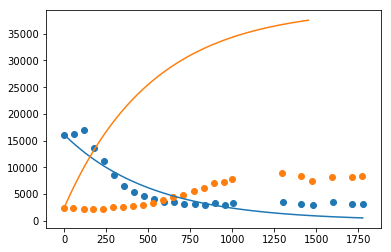

In [144]:
#
# Fitting two layers
#

t1data = K1[:,0]
p1data = K1[:,1]

t2data = K2[:,0]
p2data = K2[:,1]

r10 = 0
p10 = K1[:,1][0]
p20 = K2[:,1][0]

def make_f1(p):

    def f(x,t):
        r1,protein = x
        return [
            p['a'] - p['br'] * r1,
            p['vp'] / ( p['kp'] + r1**p['n'] ) - p['bp']*protein
        ]
    
    return f

def make_f2(p):

    def f(x,t):
        r1,r2,protein = x
        return [
            p['a'] - p['br'] * r1,
            p['vr'] / ( p['kr'] + r1**p['n'] ) - p['br'] * r2,
            p['vp'] / ( p['kp'] + r2**p['n'] ) - p['bp']*protein
        ]
    
    return f

def residual(params):
    
    x1 = spi.odeint(make_f1(params),[r10,p10],t1data)
    e1 = [ a - b for a,b in zip(x1[:,1],p1data)]
    
    x2 = spi.odeint(make_f2(params),[r10,p['r20'],p20],t2data)
    e2 = [ a - b for a,b in zip(x2[:,2],p2data)]    
    
    return np.nan_to_num(np.array(e1+e2).flatten())

def r():
    return 100*np.random.random()
p = Parameters()

p.add('a',  value=r(), min=0, max=1000)
p.add('n',  value=1, min=0,max=4)
p.add('vp', value=r(), min=0, max=1000)
p.add('vr', value=r(), min=0, max=1000)
p.add('bp', value=r(), min=0, max=1000)
p.add('br', value=r(), min=0, max=1000)
p.add('kp', value=r(), min=0, max=1000)
p.add('kr', value=r(), min=0, max=1000)
p.add('r20',value=r(), min=0, max=10000)

result = minimize(residual,p,method='differential_evolution')
tvals = np.linspace(0,max(t1data),100)
x1 = spi.odeint(make_f1(result.params),[r10,p10],tvals)
x2 = spi.odeint(make_f2(result.params),[r10,result.params['r20'],p20],tvals)
plt.plot(tvals,x1[:,1])
plt.plot(tvals,x2[:,2])
plt.scatter(t1data,p1data);
plt.scatter(t2data,p2data);
result

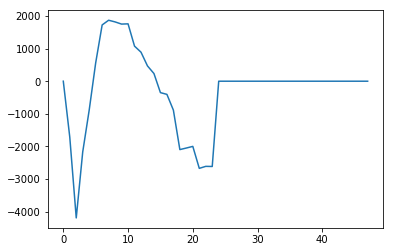

In [145]:
plt.plot(residual(result.params))

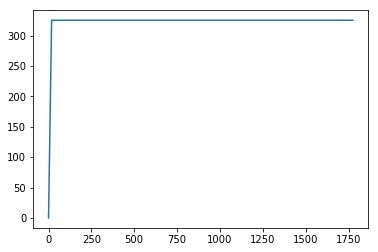

In [146]:
plt.plot(tvals,x1[:,0]); # r1 level

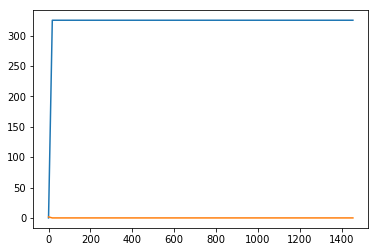

In [148]:
plt.plot(tvals,x2[:,0]); # r1 level
plt.plot(tvals,x2[:,1]); # r2 level